In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, models
from PIL import Image
from matplotlib import pyplot as plt
import os
import numpy as np
from math import log10
from torch.autograd import Variable
from random import choice
from torch.utils.data import random_split
from sklearn.metrics import mean_squared_error
import arrow
import time as t

In [2]:
torch.cuda.empty_cache()
torch.cuda.current_device()
print(torch.cuda.device_count())
print(torch.cuda.get_device_name(0))

1
GeForce RTX 2080 Ti


In [3]:
class LARSONet(nn.Module):
    def __init__(self):
        super(LARSONet, self).__init__()
        # in layer
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=64, kernel_size=3, padding=1, bias=False)
        self.relu1 = nn.ReLU(inplace=True)
        # hidden layers
        hidden_layers = []
        for i in range(15):
            hidden_layers.append(nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1, bias=False))
            hidden_layers.append(nn.BatchNorm2d(64))
            hidden_layers.append(nn.ReLU(inplace=True))
        self.mid_layer = nn.Sequential(*hidden_layers)
        # out layer
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=1, kernel_size=3, padding=1, bias=False)

    def forward(self, x):
        out1 = self.relu1(self.conv1(x))
        out = self.mid_layer(out1)
        out = self.conv3(out+out1)
        return out
    
class dp_patches(Dataset):
    def __init__(self,x,y,percent_noise):
        self.x = torch.load(x)
        self.y = torch.load(y)
        self.percent_noise = percent_noise
        self.noise = torch.randn(self.x.shape)
        self.xnoise = self.noise * self.percent_noise + self.x#*(1-self.percent_noise)
        rand_pts = torch.from_numpy(np.random.randint(0,self.x.shape[0],1000))
        self.x = self.x[rand_pts]
        self.y = self.y[rand_pts]
        self.xnoise = self.xnoise[rand_pts]
        self.z = torch.clone(self.xnoise)
    def __getitem__(self,idx):
        x = self.x[idx].to('cuda')
        z = self.xnoise[idx].to('cuda')
#         x -= torch.min(x)
#         x /= torch.max(x)
        y = self.y[idx].to('cuda')
#         y -= torch.min(y)
#         y /= torch.max(y)

        return z, y, x
    def __len__(self):
        return self.x.shape[0]

def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data,0.0,0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data,1.0,0.02)
        nn.init.constant_(m.bias.data,0)        

In [4]:
dset = dp_patches('ams_50x100.pt','mod_50x100.pt', .5)

train_dset_size = int(0.80*len(dset))
valid_dset_size = int(0.5*(len(dset) - train_dset_size))
test_dset_size = int(0.5*(len(dset) - train_dset_size))

train_dset, valid_dset, test_dset = random_split(dset,[train_dset_size,valid_dset_size,test_dset_size])

train_dataloader = DataLoader(dataset=train_dset, batch_size=2, shuffle=True, num_workers=0)
valid_dataloader = DataLoader(dataset=valid_dset, batch_size=1, shuffle=True, num_workers=0)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = LARSONet().to(device)
model.apply(weights_init)
criterion = nn.MSELoss()
lr = 1e-4
optimizer = optim.Adam(model.parameters(), lr=lr)

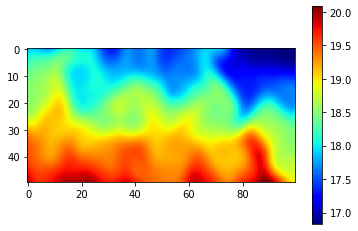

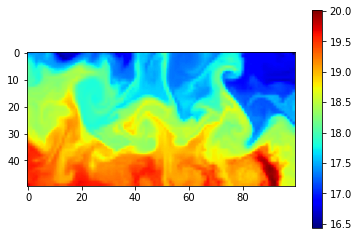

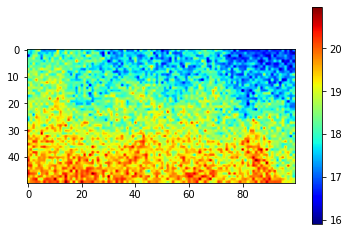

In [5]:
plt.figure()
plt.imshow(dset.x[999,0,:,:],cmap='jet')
plt.colorbar()

plt.figure()
plt.imshow(dset.y[999,0,:,:],cmap='jet')
plt.colorbar()

plt.figure()
plt.imshow(dset.z[999,0,:,:],cmap='jet')
plt.colorbar()

In [6]:
t0 = t.time()

def train(epoch):
    epoch_loss = 0
    c=0
    for z,y,x in train_dataloader:
        c+=1

        target = y-z
        predicted = model(z)

        loss = criterion(predicted, target)
        epoch_loss += loss.item()
        
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        

#         print("===> Epoch[{}]({}/{}): Loss: {:.4f}".format(epoch, c, len(train_dataloader), loss.item()))
    print("===> Epoch {} Complete: Avg. Loss: {:.4f}".format(epoch, epoch_loss / len(train_dataloader)))
    
def validate():
    validate.avg_psnr = 0
    avg_psnr = 0
    model.eval()
    with torch.no_grad():
        for zz,yy,xx in valid_dataloader:
            target = yy-zz
            predicted = model(zz)
            mse = criterion(predicted, target)
            modis = yy.cpu().numpy().squeeze().squeeze();
            amsre = zz.cpu().numpy().squeeze();
            adj = predicted.cpu().numpy().squeeze();
            psnr = 10 * np.log10(np.power(np.max(modis),2) / mean_squared_error(modis,amsre+adj))
            validate.avg_psnr += (psnr / len(valid_dataloader))
        
    print("===> Avg. PSNR: {:.4f} dB".format(validate.avg_psnr))
    
def save_checkpoint(state):
    model_out_path = "model_epoch_{}.pth".format(epoch)
    torch.save(state, model_out_path)
    print("Checkpoint saved to {}".format(model_out_path))
    
glob_psnr = 0
num_epochs = 200
coun = 1
for epoch in range(1, num_epochs + 1):
    train(epoch)
    if epoch % 2 == 0:
        validate()
        glob_psnr += validate.avg_psnr
        print("===> Running Avg. PSNR: {:.4f} dB".format(glob_psnr/(coun)))
        coun +=1

t1 = t.time()
print('it took {} seconds'.format(t1-t0))

===> Epoch 1 Complete: Avg. Loss: 0.3074
===> Epoch 2 Complete: Avg. Loss: 0.1894
===> Avg. PSNR: 22.5345 dB
===> Running Avg. PSNR: 22.5345 dB
===> Epoch 3 Complete: Avg. Loss: 0.9320
===> Epoch 4 Complete: Avg. Loss: 0.5434
===> Avg. PSNR: 24.4178 dB
===> Running Avg. PSNR: 23.4761 dB
===> Epoch 5 Complete: Avg. Loss: 0.3364
===> Epoch 6 Complete: Avg. Loss: 0.2936
===> Avg. PSNR: 27.5226 dB
===> Running Avg. PSNR: 24.8250 dB
===> Epoch 7 Complete: Avg. Loss: 0.2340
===> Epoch 8 Complete: Avg. Loss: 0.2014
===> Avg. PSNR: 28.7331 dB
===> Running Avg. PSNR: 25.8020 dB
===> Epoch 9 Complete: Avg. Loss: 0.2112
===> Epoch 10 Complete: Avg. Loss: 0.1869
===> Avg. PSNR: 29.2661 dB
===> Running Avg. PSNR: 26.4948 dB
===> Epoch 11 Complete: Avg. Loss: 0.1650
===> Epoch 12 Complete: Avg. Loss: 0.1559
===> Avg. PSNR: 28.9439 dB
===> Running Avg. PSNR: 26.9030 dB
===> Epoch 13 Complete: Avg. Loss: 0.2361
===> Epoch 14 Complete: Avg. Loss: 0.2513
===> Avg. PSNR: 27.0411 dB
===> Running Avg. PSNR

In [23]:
def save_checkpoint(state):
    date = arrow.now('US/Eastern').format('YY-MM-DD_HHmm')
    model_out_path = "model_epoch_{}_{}.pth".format(epoch,date)
    torch.save(state, model_out_path)
    print("Checkpoint saved to {}".format(model_out_path))

save_checkpoint({
    'epoch': epoch + 1,
    'arch': model,
    'state_dict': model.state_dict(),
    'optimizer' : optimizer.state_dict(),
      })


Checkpoint saved to model_epoch_200_21-07-06_1549.pth


In [10]:
torch.save(model,'CNN_noise.pth')

In [9]:
from piq import ssim, psnr
import glob
import xarray as xr
import scipy

In [12]:
class inference:
    def __init__(self,theta,range_x1,range_x2,range_y1,range_y2,percent_noise):
        
        
        self.llc = xr.open_dataset(theta)
        self.sst = np.asarray(self.llc['Theta'])
        self.sst_pil = Image.fromarray(self.sst)
        self.sst_pil_large = self.sst_pil.resize((self.sst_pil.width*2,self.sst_pil.height*2))
        self.sst_1km = np.asarray(self.sst_pil_large)
    
        self.foot = np.asarray(scipy.io.loadmat('mean_along_scan_footprint.mat')['footAverage'])
        self.foot_pil = Image.fromarray(self.foot)
        self.foot_pil_large = self.foot_pil.resize((self.foot_pil.width*4,self.foot_pil.height*4))
        self.foot_large = np.asarray(self.foot_pil_large)/16

        self.sst = torch.from_numpy(self.sst_1km.copy()).unsqueeze(0).unsqueeze(0).float(); #print(self.sst.shape)
        self.foot = torch.from_numpy(self.foot_large.copy()).unsqueeze(0).unsqueeze(0).float(); #print(self.foot.shape)

        self.modisfoot = torch.from_numpy(np.ones((10,10))/100).unsqueeze(0).unsqueeze(0).float(); #print(self.modisfoot.shape)

        self.amsre = torch.nn.functional.conv2d(self.sst,self.foot,stride=10); #print(self.amsre.shape)
        self.modis = torch.nn.functional.conv2d(self.sst,self.modisfoot,stride=10);

        self.modis = self.modis[:,:,:-12,:-9];# amsre footprint is larger. i don't like using padding. therefore modis has more convolved data so this cuts the excess
    
        self.target = self.modis-self.amsre
                
        self.amsre_patch = self.amsre[0,:,range_x1:range_x2,range_y1:range_y2].unsqueeze(0);print(self.amsre_patch.shape)
        self.modis_patch = self.modis[0,:,range_x1:range_x2,range_y1:range_y2].unsqueeze(0)   
        self.noise = torch.randn(self.amsre_patch.shape)
        self.percent_noise = percent_noise
        self.xnoise = self.noise * self.percent_noise + self.amsre_patch

        
        



# infer_choice = choice(glob.glob('../AQQQA/LLC_ai_sst/ThetaUVSalt/*.nc'))

# print(infer_choice)

infer_choice = 'AQQQA/LLC_ai_sst/ThetaUVSalt/LLC4320_2012-02-24T12_00_00.nc'
infer = inference((infer_choice),1850,1950,3200,3250,0.5)


class dp_patches(Dataset):
    def __init__(self,inp,target):
        self.x = inp
        self.y = target
        self.z = self.y - self.x
    def __getitem__(self,idx):
        x = self.x[idx].to('cuda')
        return x
    def __len__(self):
        return self.x.shape[0]
    
ds = dp_patches(infer.xnoise, infer.modis_patch)
dl = DataLoader(ds,shuffle=False)

with torch.no_grad():
    model.eval()
    for i in dl:
        prediction = model(i)

torch.Size([1, 1, 100, 50])


In [30]:
from pyresample import load_area, SwathDefinition
from pyresample.kd_tree import resample_nearest

In [65]:
am = xr.open_dataset('real_data/20111004060552-REMSS-L2P_GHRSST-SSTsubskin-AMSRE-l2b_v07a_r50096.dat-v02.0-fv01.0.nc')
x = torch.from_numpy(np.array(am['sea_surface_temperature'])).unsqueeze(0).unsqueeze(0)

In [66]:
area_def = load_area('pyresample/areas.yaml','pc_world')

In [67]:
amlon = np.array(am['lon'])
amlat = np.array(am['lat'])
am = np.array(x)

In [68]:
swath_def = SwathDefinition(amlon,amlat)
result = resample_nearest(swath_def,am,area_def,
                          radius_of_influence=10000,fill_value=None)

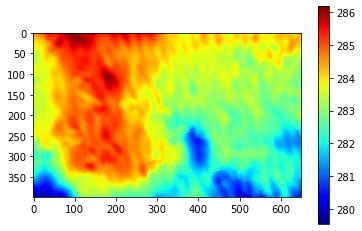

In [92]:
plt.imshow(result[9500:9900,13850:14500],cmap='jet')
plt.colorbar()

In [88]:
yo = torch.from_numpy(np.array(result[9500:9900,13850:14500]-273.15)).unsqueeze(0).unsqueeze(0)
type(yo)

torch.Tensor

In [89]:
ds = dp_patches(yo,yo)

In [90]:
dl = DataLoader(ds,shuffle=False)
with torch.no_grad():
    model.eval()
    for i in dl:
        prediction = model(i)

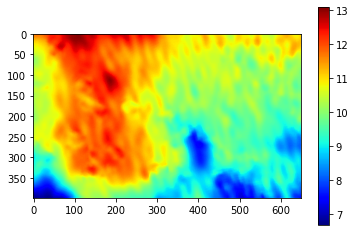

In [94]:
plt.imshow(prediction.cpu()[0,0,:,:] + yo[0,0,:,:],cmap='jet')
plt.colorbar()

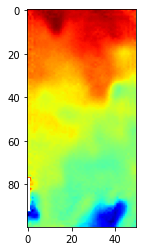

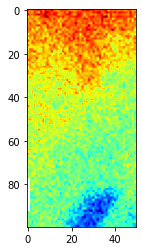

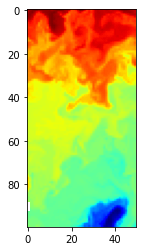

In [21]:
plt.imshow(prediction.cpu()[0,0,:,:] + ds.x.cpu()[0,0,:,:],cmap='jet')
plt.figure()
plt.imshow(ds.x.cpu()[0,0,:,:],cmap='jet')
plt.figure()
plt.imshow(ds.y.cpu()[0,0,:,:],cmap='jet')

In [96]:
pwd

'/home/albertl_uri_edu'

In [97]:
amsr2 = torch.load('dlfromopendap/amsre2.pt')

In [102]:
amsr2.shape

(12960, 17280)

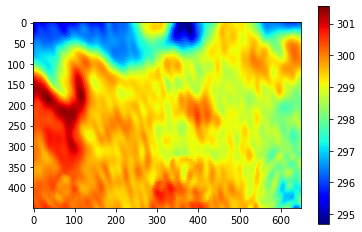

In [158]:
plt.imshow(amsr2[3600:4050,5200:5850],cmap='jet')
plt.colorbar()

In [152]:
amsr2arr = amsr2[3600:4000,5200:5850] - 273.15
amsr2arr = np.where(np.isfinite(amsr2arr) == True, amsr2arr,np.nan)

In [153]:
amsr2arr.shape

(400, 650)

In [117]:
type(amsr2arr)

numpy.ndarray

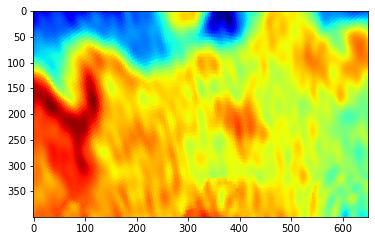

In [157]:
plt.imshow(amsr2arr,cmap='jet')

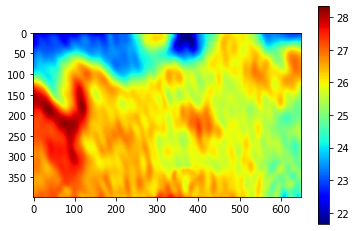

In [156]:
yoo = torch.from_numpy(amsr2arr).unsqueeze(0).unsqueeze(0)
ds = dp_patches(yoo,yoo)
dl = DataLoader(ds,shuffle=False)
with torch.no_grad():
    model.eval()
    for i in dl:
        prediction = model(i)
plt.imshow(prediction.cpu()[0,0,:,:] + yoo[0,0,:,:],cmap='jet')
plt.colorbar()

In [76]:
def zero_to_one(inp):
    xmin = torch.min(inp)
    inp -= xmin
    xmax = torch.max(inp)
    inp /= xmax
    return inp

In [21]:
amsreCNN_noise = np.asarray(infer.xnoise[0,0,:-4,:-4])
print(amsreCNN_noise.shape)

modisCNN_noise = np.asarray(infer.modis_patch[0,0,:-4,:-4])
print(modisCNN_noise.shape)

predictedCNN_noise = np.asarray(prediction.cpu()[0,0,:-4,:-4]+infer.xnoise.cpu()[0,0,:-4,:-4])
print(predictedCNN_noise.shape)

amsreGRAD = np.asarray(apmag[0,0,:,:]);
modisGRAD = np.asarray(mpmag[0,0,:,:])
predictedGRAD = np.asarray(cpmag[0,0,:,:])

np.savez('CNNimages_noise_withgrads.npz',x=amsreCNN_noise,y=modisCNN_noise,z=predictedCNN_noise,a=amsreGRAD,b=modisGRAD,c=predictedGRAD)

(220, 220)
(220, 220)
(220, 220)


<Figure size 432x288 with 0 Axes>

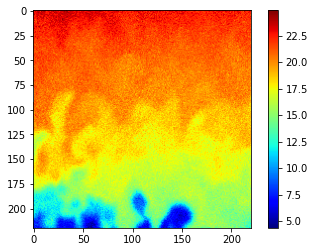

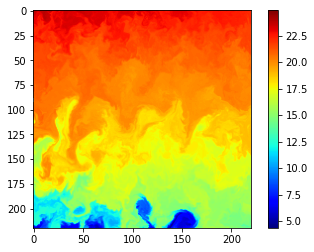

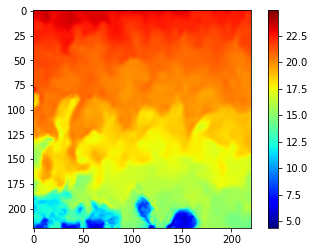

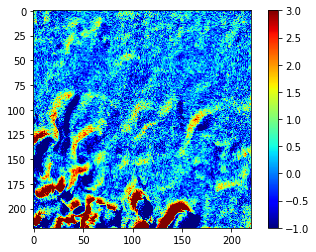

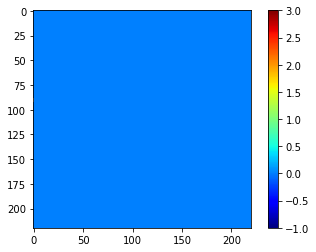

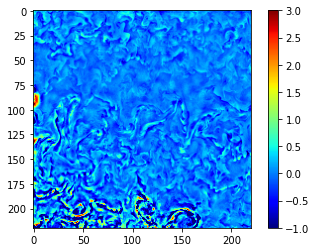

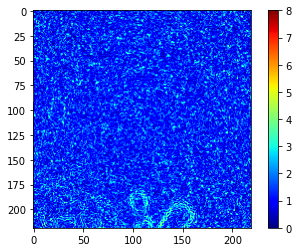

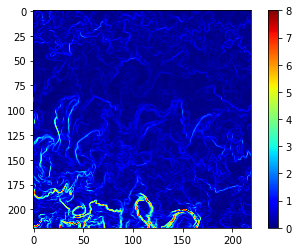

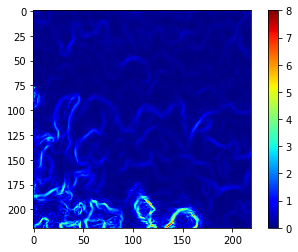

In [16]:
plt.figure()

plt.figure()
plt.imshow(infer.xnoise.cpu()[0,0,:-4,:-4],cmap='jet')
vmin, vmax = plt.gci().get_clim()
plt.colorbar()

plt.figure()
plt.imshow(infer.modis_patch.cpu()[0,0,:-4,:-4],cmap='jet',vmin=vmin,vmax=vmax)
plt.colorbar()


plt.figure()
plt.imshow(prediction.cpu()[0,0,:-4,:-4]+infer.xnoise.cpu()[0,0,:-4,:-4],cmap='jet',vmin=vmin,vmax=vmax)
plt.colorbar()


plt.figure()
plt.imshow(infer.modis_patch[0,0,:-4,:-4]-infer.xnoise[0,0,:-4,:-4],cmap='jet',vmin=-1,vmax=3)
plt.colorbar()

plt.figure()
plt.imshow(infer.modis_patch[0,0,:-4,:-4]-infer.modis_patch[0,0,:-4,:-4],cmap='jet',vmin=-1,vmax=3)
plt.colorbar()

plt.figure()
plt.imshow(infer.modis_patch[0,0,:-4,:-4]-(prediction.cpu()[0,0,:-4,:-4]+infer.xnoise.cpu()[0,0,:-4,:-4]),cmap='jet',vmin=-1,vmax=3)
plt.colorbar()


g1 = torch.from_numpy(np.array([[1,1],[-1,-1]])).unsqueeze(0).unsqueeze(0).float()
g2 = torch.from_numpy(np.array([[1,-1],[1,-1]])).unsqueeze(0).unsqueeze(0).float()

modis_patch_g1 = torch.nn.functional.conv2d(infer.modis_patch[:,:,:-4,:-4],g1)
modis_patch_g2 = torch.nn.functional.conv2d(infer.modis_patch[:,:,:-4,:-4],g2)

mpmag = torch.sqrt(torch.pow(modis_patch_g1,2)+torch.pow(modis_patch_g2,2))

amsre_patch_g1 = torch.nn.functional.conv2d(infer.xnoise[:,:,:-4,:-4],g1)
amsre_patch_g2 = torch.nn.functional.conv2d(infer.xnoise[:,:,:-4,:-4],g2)

apmag = torch.sqrt(torch.pow(amsre_patch_g1,2)+torch.pow(amsre_patch_g2,2))

correct_g1 = torch.nn.functional.conv2d(prediction.cpu()[:,:,:-4,:-4]+infer.xnoise.cpu()[:,:,:-4,:-4],g1)
correct_g2 = torch.nn.functional.conv2d(prediction.cpu()[:,:,:-4,:-4]+infer.xnoise.cpu()[:,:,:-4,:-4],g2)

cpmag = torch.sqrt(torch.pow(correct_g1,2)+torch.pow(correct_g2,2))


plt.figure()
plt.imshow(apmag[0,0,:,:],cmap='jet',vmin=0,vmax=8)
plt.colorbar()

plt.figure()
plt.imshow(mpmag[0,0,:,:],cmap='jet',vmin=0,vmax=8)
plt.colorbar()

plt.figure()
plt.imshow(cpmag[0,0,:,:],cmap='jet',vmin=0,vmax=8)
plt.colorbar()

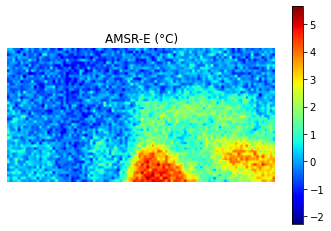

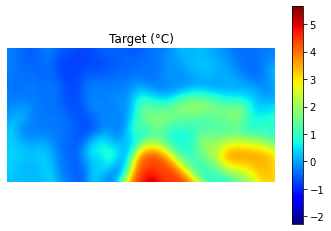

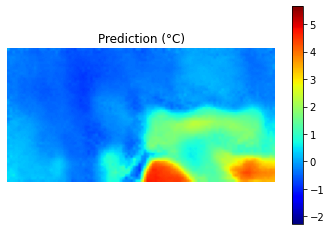

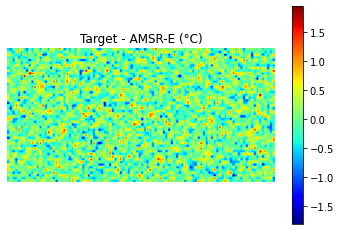

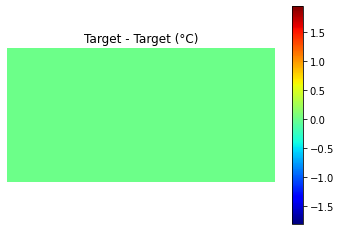

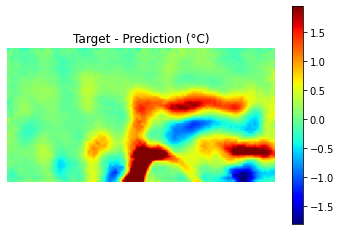

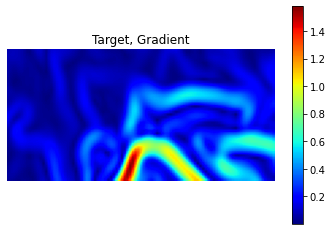

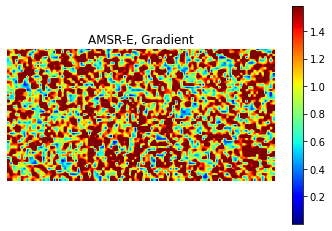

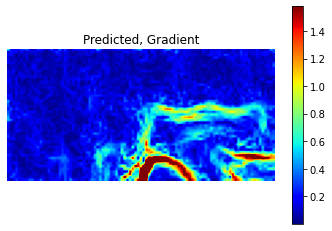

In [13]:
g1 = torch.from_numpy(np.array([[1,1],[-1,-1]])).unsqueeze(0).unsqueeze(0).float()
g2 = torch.from_numpy(np.array([[1,-1],[1,-1]])).unsqueeze(0).unsqueeze(0).float()

with torch.no_grad():
    for zz,xx,yy in valid_dataloader:
        target = yy-xx
        predicted = model(zz)
        

        modis_patch_g1 = torch.nn.functional.conv2d(yy.cpu(),g1)
        modis_patch_g2 = torch.nn.functional.conv2d(yy.cpu(),g2)

        mpmag = torch.sqrt(torch.pow(modis_patch_g1,2)+torch.pow(modis_patch_g2,2))

        amsre_patch_g1 = torch.nn.functional.conv2d(zz.cpu(),g1)
        amsre_patch_g2 = torch.nn.functional.conv2d(zz.cpu(),g2)

        apmag = torch.sqrt(torch.pow(amsre_patch_g1,2)+torch.pow(amsre_patch_g2,2))

        correct_g1 = torch.nn.functional.conv2d(predicted.cpu()[0,0,:,:]+zz.cpu(),g1)
        correct_g2 = torch.nn.functional.conv2d(predicted.cpu()[0,0,:,:]+zz.cpu(),g2)

        cpmag = torch.sqrt(torch.pow(correct_g1,2)+torch.pow(correct_g2,2))
        

        plt.figure()
        plt.imshow(zz.cpu()[0,0,:,:],cmap='jet')
        plt.title('AMSR-E (°C)')
        vmin, vmax = plt.gci().get_clim()
        plt.colorbar()
        plt.axis('off')
        plt.savefig('NASA_report/CNN_noisy_amsre.png')
        
        plt.figure()
        plt.imshow(yy.cpu()[0,0,:,:],cmap='jet',vmin=vmin,vmax=vmax)
        plt.title('Target (°C)')
        plt.colorbar()
        plt.axis('off')
        plt.savefig('NASA_report/CNN_noisy_target.png')

        plt.figure()
        plt.imshow(predicted.cpu()[0,0,:,:]+zz.cpu()[0,0,:,:],cmap='jet',vmin=vmin,vmax=vmax)
        plt.title('Prediction (°C)')
        plt.colorbar()
        plt.axis('off')

        plt.savefig('NASA_report/CNN_noisy_predicted.png')
        
        plt.figure()
        plt.imshow(yy.cpu()[0,0,:,:] - zz.cpu()[0,0,:,:],cmap='jet')
        plt.title('Target - AMSR-E (°C)')
        vmin, vmax = plt.gci().get_clim()
        plt.colorbar()
        plt.axis('off')
        plt.savefig('NASA_report/CNN_noisy_target-amsre.png')
        
        plt.figure()
        plt.imshow(yy.cpu()[0,0,:,:] - yy.cpu()[0,0,:,:],cmap='jet',vmin=vmin,vmax=vmax)
        plt.title('Target - Target (°C)')
        plt.colorbar()
        plt.axis('off')
        plt.savefig('NASA_report/CNN_noisy_target-target.png')

        plt.figure()
        plt.imshow(yy.cpu()[0,0,:,:] - (predicted.cpu()[0,0,:,:]+zz.cpu()[0,0,:,:]),cmap='jet',vmin=vmin,vmax=vmax)
        plt.title('Target - Prediction (°C)')
        plt.colorbar()
        plt.axis('off')
        plt.savefig('NASA_report/CNN_noisy_target-prediction.png')
        
        
        plt.figure()
        plt.title('Target, Gradient')
        plt.imshow(mpmag[0,0,:,:],cmap='jet')
        vmin, vmax = plt.gci().get_clim()
        plt.colorbar()
        plt.axis('off')
        plt.savefig('NASA_report/CNN_noisy_target_gradient.png')
        
        plt.figure()
        plt.title('AMSR-E, Gradient')
        plt.imshow(apmag[0,0,:,:],cmap='jet',vmin=vmin,vmax=vmax)
        plt.colorbar()
        plt.axis('off')
        plt.savefig('NASA_report/CNN_noisy_amsre_gradient.png')
        
        plt.figure()
        plt.title('Predicted, Gradient')
        plt.imshow(cpmag[0,0,:,:],cmap='jet',vmin=vmin,vmax=vmax)
        plt.colorbar()
        plt.axis('off')
        plt.savefig('NASA_report/CNN_noisy_predicted_gradient.png')
        
        break

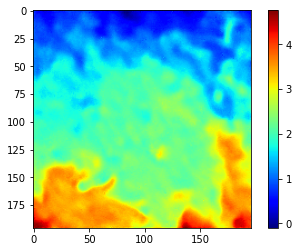

In [12]:
plt.imshow(predicted.cpu()[0,0,:,:]+zz.cpu()[0,0,:,:],cmap='jet')
plt.colorbar()

In [30]:
print(torch.nn.functional.mse_loss(b,a))
print(torch.nn.functional.mse_loss(b,c))

tensor(0.0028)
tensor(0.0005)


0.24956742
0.066702455
0.002754903
0.0030356324
25.598936986252898
25.177508165217528


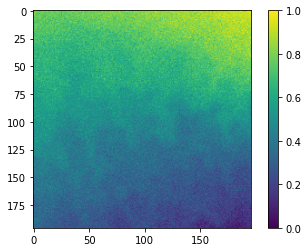

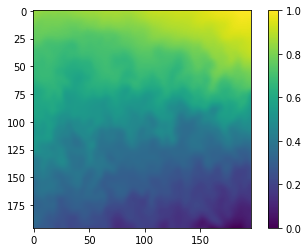

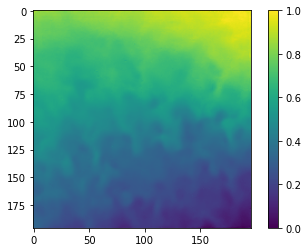

In [31]:
a = zz.cpu()[0,0,:,:]
b = yy.cpu()[0,0,:,:]
c = predicted.cpu()[0,0,:,:]+zz.cpu()[0,0,:,:]

print(mean_squared_error(b,a))
print(mean_squared_error(b,c))

amin = torch.min(a)
a -= amin

amax = torch.max(a)
a /= amax
plt.figure()
plt.imshow(a)
plt.colorbar()

bmin = torch.min(b)
b -= bmin

bmax = torch.max(b)
b /= bmax

plt.figure()
plt.imshow(b)
plt.colorbar()

cmin = torch.min(c)
c -= cmin

cmax = torch.max(c)
c /= cmax

plt.figure()
plt.imshow(c)
plt.colorbar()

print(mean_squared_error(a,b))
print(mean_squared_error(a,c))

print(10*np.log10(np.power(np.max(a.numpy().reshape(-1)),2) / mean_squared_error(a,b)))
print(10*np.log10(np.power(np.max(a.numpy().reshape(-1)),2) / mean_squared_error(a,c)))
